# Smooth for each level of categorical variable

To smooth for each level of a categorical variable, there are two primary methods:

1. Using a categorical by variable
2. Using the [`FactorSmooth`][pymgcv.basis_functions.FactorSmooth] basis function

This example shows both methods. First, we perform the imports and create a toy dataset 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pymgcv.plot as gplt
from pymgcv.basis_functions import FactorSmooth
from pymgcv.gam import GAM
from pymgcv.terms import L, S

rng = np.random.default_rng(0)
x = rng.uniform(-1, 1, size=200)
group = pd.Series(
    rng.choice(["A", "B", "C"], size=len(x)),
    dtype=pd.CategoricalDtype(categories=["A", "B", "C"]),
)

y = rng.normal(scale=0.1, size=len(x))
y[group == "A"] += np.sin(x * 2)[group == "A"]
y[group == "B"] += (x**2)[group == "B"] + 1 
y[group == "C"] += -(x**2)[group == "C"] - 1 
data = pd.DataFrame({"x": x, "y": y, "group": group})


#### Option 1: Categorical by variables:
`S("x", by="group")` can be used to fit a seperate smooth for each level of the factor, (or analagously with [`T`][pymgcv.terms.T]):

- Such smooths are centered, so we generally must include the categorical variable as a linear term too, i.e. `L("group")`.
- If the intercept is left in the model, the partial effect of the first level `L("group")` will be fixed to zero mean/variance to avoid non-identifiability with the intercept term.
- Alternativly, we can remove the intercept, in which case all levels of the linear term will have non-zero effects. Below we use this approach by setting ``add_intercepts=False`` .


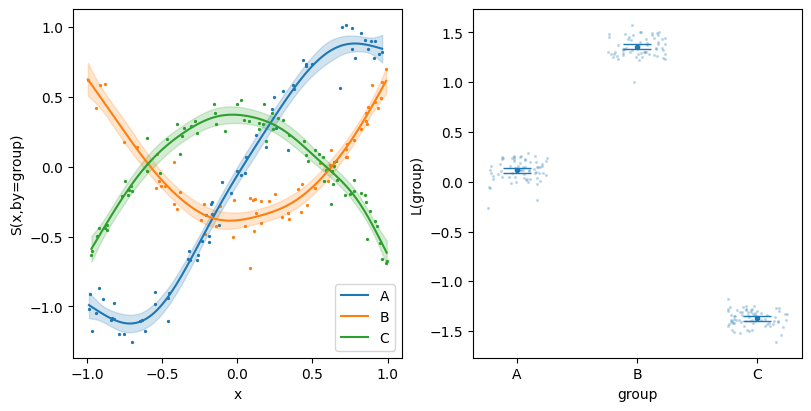

In [2]:
gam = GAM({"y": S("x", by="group") + L("group")}, add_intercepts=False)
gam.fit(data)
fig, ax = gplt.plot(gam, scatter=True)
fig.set_size_inches(8, 4)
fig.show()

#### Option 2: Using Factor Smooth basis  
In contrast using the [`FactorSmooth`][pymgcv.basis_functions.FactorSmooth] basis leads to:

1. Sharing a smoothing parameter
2. Non-centered smooths
3. The null space components being penalized (e.g. including level-specific intercepts). The penalization means, this term can be used with an intercept term in the model without introducing any indeterminacy

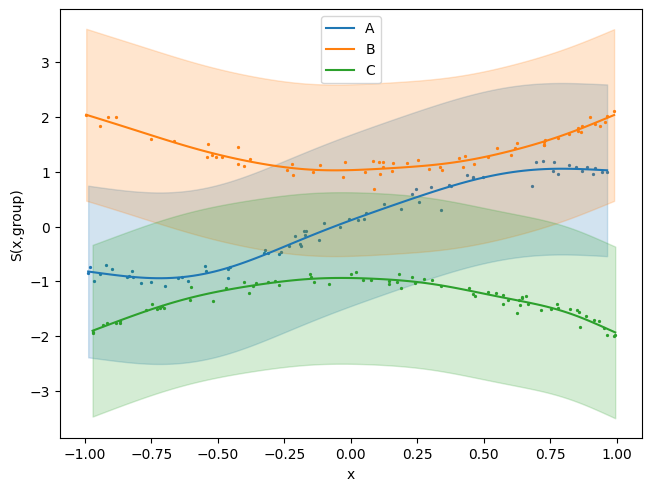

In [3]:
gam = GAM({"y": S("x", "group", bs=FactorSmooth())})
fit = gam.fit(data)
gplt.plot(gam, scatter=True)
plt.show()

!!! note

    The uncertainty looks much greater for the [`FactorSmooth`][pymgcv.basis_functions.FactorSmooth] approach. This is because it includes uncertainty in the intercept term, whereas the first approach does not. 